## task:
we need to map a peak to one chunk in the bed file, and then see if the other chunk in contact with it is the promoter of any gene.

* SNP to peak definition:  
+/- 250bp of peak region

* promoter definition:  
5kb upstream of gene TSS 

* in contact definition:  
each row in the Hi-C file defines in contact.

* peak-HiC and promoter-HiC contact
20% overlap of peak size between peak and hic, 20% overlap of promoter size between promoter and hic.

## format:
* Hi-C files  

    * [PsychEncode data](https://science.sciencemag.org/content/362/6420/eaat4311), obtained from Siwei, in hg19, a Hi-C bed file with the name XXX.50000_blocks.bed, each number A in the 2nd/3rd column represents a fragment that spans from A to A+50000.
    * [Nature 2016](https://www.nature.com/articles/nature19847)
    * [NG 2019](http://dx.doi.org/10.1038/s41588-019-0472-1),
    in hg19,
    `wget https://static-content.springer.com/esm/art%3A10.1038%2Fs41588-019-0472-1/MediaObjects/41588_2019_472_MOESM4_ESM.xlsx`


* ASoC SNP file  
in hg38. from Yifan.

* peak file  
in hg38. CN means glutamatergic neurons, and I guess we should use Hi-C files starting with 'Neu';
NSC means neural progenitor cells, and I guess we should use Hi-C files starting with 'NPC'. from Yifan.

* gene anno file  
in hg19. `genecode.v29lift37.genes` from zhongshan.

In [2]:
cd /project2/xinhe/simingz/neuron_atac_seq/HiC

/project2/xinhe/simingz/neuron_atac_seq/HiC


In [3]:
# promoter annotation file
!mv genecode.v29lift37.genes genecode.v29lift37.genes.ori
!awk -F'\t' '$2 >0 && $1 ~ /chr/ && $1 != "chrM" {print $0}' genecode.v29lift37.genes.ori > genecode.v29lift37.genes
!awk 'BEGIN{FS="\t";OFS="\t"}{if($4=="+"){print $1,$2-3000,$2,$5}else{print $1,$3,$3+3000,$5}}'  genecode.v29lift37.genes > genecode.v29lift37.genes.promoter

In [2]:
import pybedtools
from pyliftover import LiftOver
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import subprocess
from brokenaxes import brokenaxes
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

In [96]:
def snp2gene(snpf, peakf, hicf, annof, outtag):
    '''snp to peak to gene promoter
    '''
    # snp to peak
    peakflsize = 250
    snps = pybedtools.BedTool(snpf)
    peaks = pybedtools.BedTool(peakf)
    peaksfl = peaks.slop(genome = 'hg38', b = peakflsize)
    snp2peak = snps.intersect(peaksfl, wb=True)
    snp2peak.saveas(outtag + '.snp2peak.bed')  
    
    # snp2peak liftover
    lo = LiftOver('hg38', 'hg19')
    with open(outtag + '.snp2peak.lo.bed', 'w') as snp2peaklo:
        for snp in snp2peak:
            s = lo.convert_coordinate(snp.fields[8], int(snp.fields[9]))
            e = lo.convert_coordinate(snp.fields[8], int(snp.fields[10]))
            if len(s) !=0 and len(e) != 0:
                if s[0][0] == e[0][0] and s[0][1] < e[0][1]:
                    peaklo = [s[0][0], str(s[0][1]), str(e[0][1])]
                    snp2peaklo.write('\t'.join(peaklo + list(snp)) + '\n')
    
    # annotate with HiC contact
    hics = pybedtools.BedTool(hicf)
    snppeak = pybedtools.BedTool(outtag + '.snp2peak.lo.bed')
    snppeakhic = snppeak.intersect(hics, wao=True, f=0.2)
    snppeakhic.saveas(outtag + '.snp2peak.lo.hic1.bed')
    
    # annotate the other end with promoter info
    snppeakhic1 = pybedtools.BedTool([[i[14]] + i[17:19] + i[0:17] + [i[19]] for i in snppeakhic if i[19]!='0'])
    annos= pybedtools.BedTool(annof)
    snppeakhic2 = snppeakhic1.intersect(annos, wao= True, F=0.2)
    snppeakhic2.saveas(outtag + '.snp2peak.lo.hic2.bed')
    out = pybedtools.BedTool([i for i in snppeakhic2 if i[25] != '0'])
    
    # write output
    with open(outtag + '.bed', 'w') as outfile:
        # outfile.write('\t'.join(['SNP.chr','SNP.start','SNP.end','SNP.label','SNP','SNP','SNP','SNP', 'peak.chr', 'peak.start', 'peak.end', 'geneID']) +'\n')
        for outr in out:
            outfile.write('\t'.join(outr[6:17] + [outr[24]]) + '\n')
    return(out)

## PsychEncode Data

In [ ]:
hicdis = []
with open('Neu.50000_blocks.bed', 'r') as f:
    csv_reader = csv.reader(f, delimiter = '\t')
    for row in csv_reader:
        try:
            hicdis.append(abs(int(row[2])-int(row[1])))
        except IndexError:
            print(row)
b=plt.hist(hicdis,200)
plt.title('HiC contact size distribution')

In [7]:
# HiC file to canonical bed file and duplicate each entry by switching order of the two ends
!awk -F'\t' '{print "chr"$1"\t"$2"\t"$2+50000"\t"$3"\t"$3+50000"\nchr"$1"\t"$3"\t"$3+50000"\t"$2"\t"$2+50000}' NPC.50000_blocks.bed > NPC.50000_blocks.converted.bed
!awk -F'\t' '{print "chr"$1"\t"$2"\t"$2+50000"\t"$3"\t"$3+50000"\nchr"$1"\t"$3"\t"$3+50000"\t"$2"\t"$2+50000}' Neu.50000_blocks.bed > Neu.50000_blocks.converted.bed
!awk -F'\t' '{print "chr"$1"\t"$2"\t"$2+100000"\t"$3"\t"$3+100000"\nchr"$1"\t"$3"\t"$3+100000"\t"$2"\t"$2+100000}' NPC.100000_blocks.bed > NPC.100000_blocks.converted.bed
!awk -F'\t' '{print "chr"$1"\t"$2"\t"$2+100000"\t"$3"\t"$3+100000"\nchr"$1"\t"$3"\t"$3+100000"\t"$2"\t"$2+100000}' Neu.100000_blocks.bed > Neu.100000_blocks.converted.bed

### CN

In [30]:
snpf = 'CN_20_ASoC_FDR0.05.bed'
peakf = 'CN_merged_all_20_peaks.hotspot.bed'
hicf = 'Neu.50000_blocks.converted.bed'
annof = 'genecode.v29lift37.genes.promoter'
outtag = 'CN.hic'
out = snp2gene(snpf, peakf, hicf, annof, outtag)

In [31]:
# histograph
nsnp = !wc -l {snpf}
nsnp = int(nsnp[0].split(' ')[0]) - 1
hicsnp = pd.read_csv("CN.hic.bed", sep="\t", header=None) 
count0 = hicsnp[3].value_counts()
nix = np.append(np.array(count0),np.zeros(nsnp - len(hicsnp[3].unique()))) # add 0 contact snps.

Text(0.5,1,'Distribution of number of interactions')

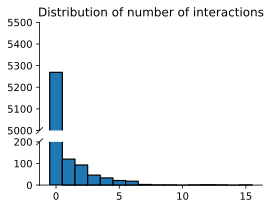

In [32]:
fig= plt.figure(figsize=(4,3))
bax = brokenaxes(ylims=((0, 200), (5000,5500)), hspace=.15)
bax.hist(nix, bins=np.arange(min(nix), max(nix) + 2, 1) - 0.5, edgecolor='black', linewidth=1.2,  )
# plt.xticks(np.arange(min(nix), max(nix) + 1, 1), np.arange(min(nix), max(nix) + 1, 1, dtype = int))
# bax.spines["top"].set_visible(False)
# bax.spines["right"].set_visible(False)
plt.title("Distribution of number of interactions")

### NSC

In [11]:
snpf = 'NSC_20_ASoC_FDR0.05.bed'
peakf = 'NSC_merged_all_20_peaks.hotspot.bed'
hicf = 'NPC.50000_blocks.converted.bed'
annof = 'genecode.v29lift37.genes.promoter'
outtag = 'NSC.hic'
out = snp2gene(snpf, peakf, hicf, annof, outtag)

In [12]:
# histograph
nsnp = !wc -l {snpf}
nsnp = int(nsnp[0].split(' ')[0]) - 1
hicsnp = pd.read_csv("NSC.hic.bed", sep="\t", header=None) 
count0 = hicsnp[3].value_counts()
nix = np.append(np.array(count0),np.zeros(nsnp - len(hicsnp[3].unique()))) # add 0 contact snps.

Text(0.5,1,'Distribution of number of interactions')

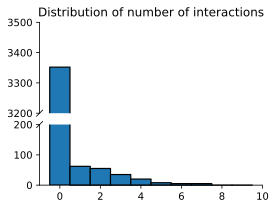

In [13]:
fig= plt.figure(figsize=(4,3))
bax = brokenaxes(ylims=((0, 200), (3200,3500)), hspace=.15)
bax.hist(nix, bins=np.arange(min(nix), max(nix) + 1, 1) - 0.5, edgecolor='black', linewidth=1.2, )
#plt.xticks(np.arange(min(nix), max(nix) + 1, 1), np.arange(min(nix), max(nix) + 1, 1, dtype = int))
#bax.spines["top"].set_visible(False)
#bax.spines["right"].set_visible(False)
plt.title("Distribution of number of interactions")

## NG 2019

In [100]:
# process Hi-C data
df = pd.read_excel("41588_2019_472_MOESM4_ESM.xlsx", sheet_name = "excitatory interactions" )
df.to_csv("41588_2019_472_MOESM4_ESM-excitatory.csv", sep="\t")

df = pd.read_excel("41588_2019_472_MOESM4_ESM.xlsx", sheet_name = "hippocampal interactions" )
df.to_csv("41588_2019_472_MOESM4_ESM-hippo.csv", sep="\t")

df = pd.read_excel("41588_2019_472_MOESM4_ESM.xlsx", sheet_name = "motor interactions" )
df.to_csv("41588_2019_472_MOESM4_ESM-motor.csv", sep="\t")

df = pd.read_excel("41588_2019_472_MOESM4_ESM.xlsx", sheet_name = "astrocyte interactions" )
df.to_csv("41588_2019_472_MOESM4_ESM-astro.csv", sep="\t")

In [101]:
!awk -F'\t' '$2 == $6 {print $2"\t"$3"\t"$4"\t"$7"\t"$8}' 41588_2019_472_MOESM4_ESM-hippo.csv > NG2019-HiC-hippo.converted.bed
!awk -F'\t' '$2 == $6 {print $2"\t"$7"\t"$8"\t"$3"\t"$4}' 41588_2019_472_MOESM4_ESM-hippo.csv >> NG2019-HiC-hippo.converted.bed

Text(0.5,1,'HiC contact size distribution')

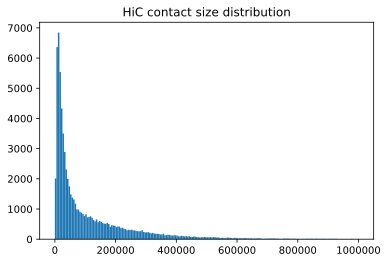

In [102]:
hicdis = []
with open('NG2019-HiC.converted.bed', 'r') as f:
    csv_reader = csv.reader(f, delimiter = '\t')
    for row in csv_reader:
        try:
            hicdis.append(abs(int(row[3])-int(row[1])))
        except IndexError:
            print(row)
b=plt.hist(hicdis,200,range=[0,1e6])
plt.title('HiC contact size distribution')

### CN

In [103]:
snpf = 'CN_20_ASoC_FDR0.05.bed'
peakf = 'CN_merged_all_20_peaks.hotspot.bed'
hicf = 'NG2019-HiC-hippo.converted.bed'
annof = 'genecode.v29lift37.genes.promoter'
outtag = 'CN.hic-hg2019'
out = snp2gene(snpf, peakf, hicf, annof, outtag)

In [105]:
# histograph
nsnp = !wc -l {snpf}
nsnp = int(nsnp[0].split(' ')[0]) - 1
hicsnp = pd.read_csv("CN.hic-hg2019.bed", sep="\t", header=None) 
count0 = hicsnp[3].value_counts()
nix = np.append(np.array(count0),np.zeros(nsnp - len(hicsnp[3].unique()))) # add 0 contact snps.

Text(0.5,1,'Distribution of number of interactions')

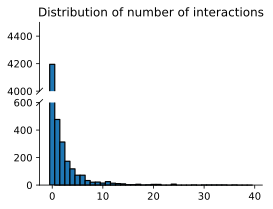

In [109]:
fig= plt.figure(figsize=(4,3))
bax = brokenaxes(ylims=((0, 600), (4000,4500)), hspace=.15)
bax.hist(nix, bins=np.arange(min(nix), max(nix) + 1, 1) - 0.5, edgecolor='black', linewidth=1.2,  )
# plt.xticks(np.arange(min(nix), max(nix) + 1, 1), np.arange(min(nix), max(nix) + 1, 1, dtype = int))
# bax.spines["top"].set_visible(False)
# bax.spines["right"].set_visible(False)
plt.title("Distribution of number of interactions")

### NSC

In [110]:
snpf = 'NSC_20_ASoC_FDR0.05.bed'
peakf = 'NSC_merged_all_20_peaks.hotspot.bed'
hicf = 'NG2019-HiC-hippo.converted.bed'
annof = 'genecode.v29lift37.genes.promoter'
outtag = 'NSC.hic-ng2019'
out = snp2gene(snpf, peakf, hicf, annof, outtag)

In [111]:
# histograph
nsnp = !wc -l {snpf}
nsnp = int(nsnp[0].split(' ')[0]) - 1
hicsnp = pd.read_csv("NSC.hic-ng2019.bed", sep="\t", header=None) 
count0 = hicsnp[3].value_counts()
nix = np.append(np.array(count0),np.zeros(nsnp - len(hicsnp[3].unique()))) # add 0 contact snps.

Text(0.5,1,'Distribution of number of interactions')

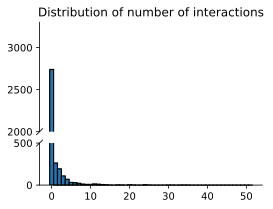

In [118]:
fig= plt.figure(figsize=(4,3))
bax = brokenaxes(ylims=((0, 500), (2000,3300)), hspace=.15)
bax.hist(nix, bins=np.arange(min(nix), max(nix) + 1, 1) - 0.5, edgecolor='black', linewidth=1.2,  )
# plt.xticks(np.arange(min(nix), max(nix) + 1, 1), np.arange(min(nix), max(nix) + 1, 1, dtype = int))
# bax.spines["top"].set_visible(False)
# bax.spines["right"].set_visible(False)
plt.title("Distribution of number of interactions")

## some QC

#### prepare data
```
!wget https://static-content.springer.com/esm/art%3A10.1038%2Fs41588-019-0472-1/MediaObjects/41588_2019_472_MOESM9_ESM.xlsx

df = pd.read_excel("41588_2019_472_MOESM9_ESM.xlsx", sheet_name='SCZ all SNPs')

df.iloc[3:, list(range(6)) + [16,20,24,28]].to_csv("1588_2019_472_MOESM9_ESM.bed", sep="\t", header= False, index= False)
```

In [ ]:
pubbed = pybedtools.BedTool('1588_2019_472_MOESM9_ESM.bed')
cnbedori = pybedtools.BedTool('CN_20_ASoC_FDR0.05.bed.hg19')

In [ ]:
inter = cnbedori.intersect(pubbed, wb= True)

In [ ]:
print(inter)